<a href="https://colab.research.google.com/github/Benj-admin/MAP583_X/blob/main/TP/TP06_stability_robustness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP06 - Stability and robustness
In this practical, we are going to investigate the stability and robustness of neural networks, during training and at inference. To do so, we will test different initialization schemes, see their effect on the regularity of the function, test different methods to improve stability in the presence of outliers in the training distribution, and learn to generate adversarial attacks on pre-trained models.

In [4]:
import io
import requests
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Part A - Weight initialization
Let's now investigate the effect of initialization on simple neural networks (MLPs).

## A.0 - Model creation
First, we need to automatically create large and deep MLPs. Create a function `MLP(dim_input, dim_output, dim_hidden, num_layers)` that returns an MLP with ReLU activations, `num_layers` layers and width `dim_hidden` using `nn.Sequential`.

Check that the MLP has the correct architecture for 1, 2 and 4 layers.

In [5]:
def MLP(dim_input, dim_output, dim_hidden, num_layers):
    if num_layers == 1:
      return nn.Sequential(nn.Linear(dim_input,dim_output))
    else :
      layers = [nn.Linear(dim_input,dim_hidden),nn.ReLU()]
      for _ in range(num_layers-2):
        layers += [nn.Linear(dim_hidden,dim_hidden),nn.ReLU()]
      layers += [nn.Linear(dim_hidden,dim_output)]
      return nn.Sequential(*layers)

In [6]:
print("Model 1 layer: ",MLP(10,2,5,1))
print("Model 2 layer: ",MLP(10,2,5,2))
print("Model 4 layer: ",MLP(10,2,5,4))

Model 1 layer:  Sequential(
  (0): Linear(in_features=10, out_features=2, bias=True)
)
Model 2 layer:  Sequential(
  (0): Linear(in_features=10, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=2, bias=True)
)
Model 4 layer:  Sequential(
  (0): Linear(in_features=10, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=5, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5, out_features=2, bias=True)
)


## A.1 - Neural networks at initialization
We are now going to experiment with initialization. First, let's plot the function created by an MLP at initialization.

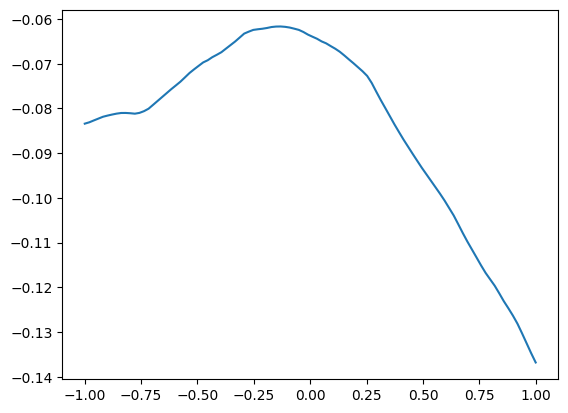

In [7]:
model = MLP(1,1,100,4)
x = torch.linspace(-1,1,100).view(-1,1)
y = model(x)

plt.plot(x.detach().numpy(),y.detach().numpy())
plt.show()

Plot multiple functions on the same figure.

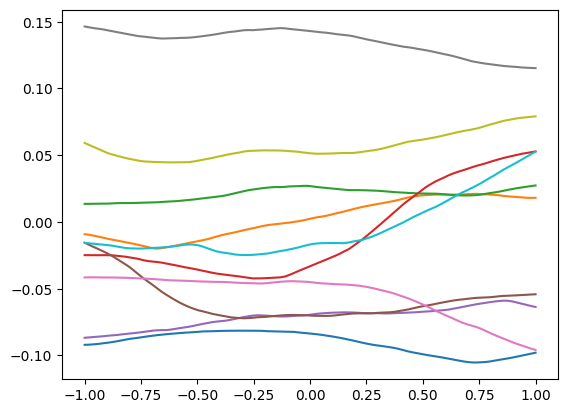

In [8]:
for _ in range(10):
  model = MLP(1,1,100,4)
  x = torch.linspace(-1,1,100).view(-1,1)
  y = model(x)

  plt.plot(x.detach().numpy(),y.detach().numpy())
plt.show()

Increase the number of layers to 10. What happens? Is that a problem for learning?

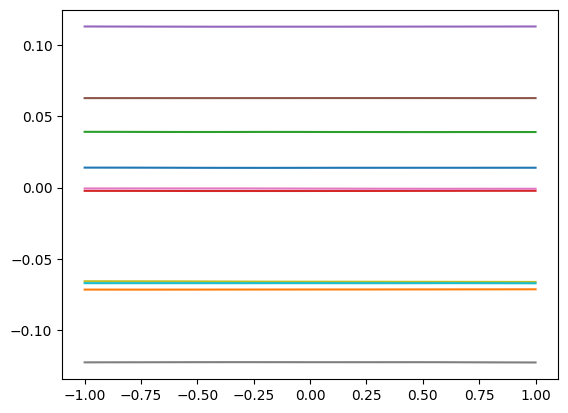

In [9]:
for _ in range(10):
  model = MLP(1,1,100,10)
  x = torch.linspace(-1,1,100).view(-1,1)
  y = model(x)

  plt.plot(x.detach().numpy(),y.detach().numpy())
plt.show()

We are now going to fix this issue by applying a different initialization.
Create a function that initializes all weights of the MLP by using functions in [`nn.init`](https://pytorch.org/docs/stable/nn.init.html).

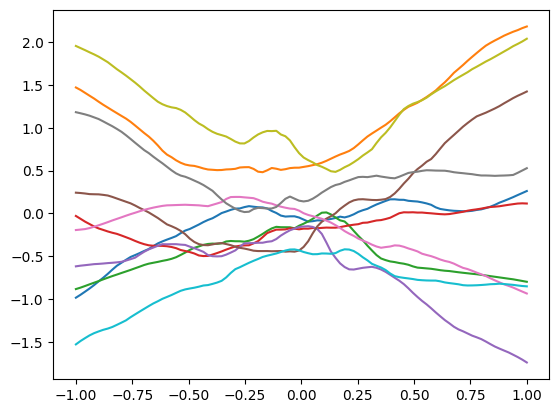

In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity ="relu")

model = MLP(1, 1 , 100, 10)
for _ in range(10):
    model.apply(init_weights)
    x = torch.linspace(-1, 1, 100).view(-1, 1)
    y = model(x)

    plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

## A.2 - Fixing the issue with batch normalization
Add a batch norm `nn.BatchNorm1d` layer after each hidden layer.

In [11]:
def MLP_bn(dim_input, dim_output, dim_hidden, num_layers):
    if num_layers == 1:
      return nn.Sequential(nn.Linear(dim_input,dim_output))
    else :
      layers = [nn.Linear(dim_input,dim_hidden),nn.ReLU()]
      for _ in range(num_layers-2):
        layers += [nn.Linear(dim_hidden,dim_hidden),nn.BatchNorm1d(dim_hidden),nn.ReLU()]
      layers += [nn.Linear(dim_hidden,dim_output)]
      return nn.Sequential(*layers)

How is the result different at initialization? Plot several functions generated by a 10-layer MLP at initialization (with default initialization).

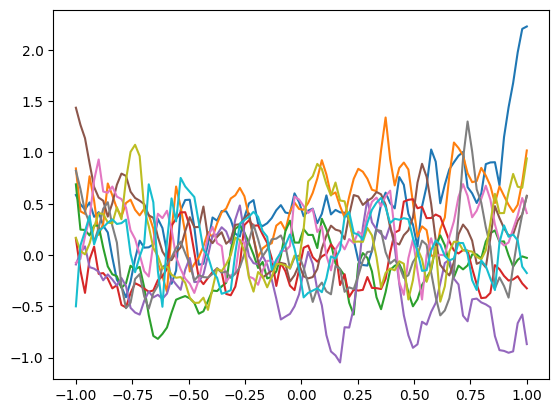

In [12]:
for _ in range(10):
  model = MLP_bn(1,1,100,10)
  x = torch.linspace(-1,1,100).view(-1,1)
  y = model(x)

  plt.plot(x.detach().numpy(),y.detach().numpy())
plt.show()

⚠ **Careful though:** Batch norm depends on the **whole batch**, and uses the **training mean and standard deviation** during **evaluation**.

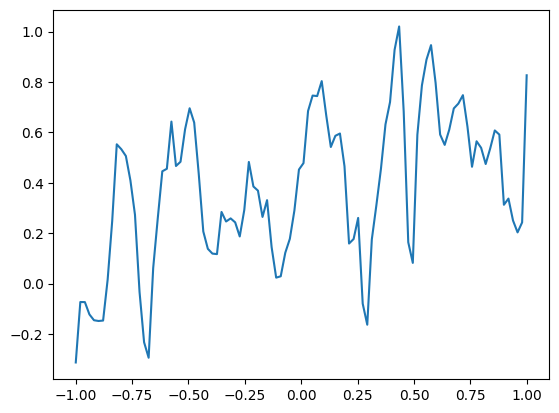

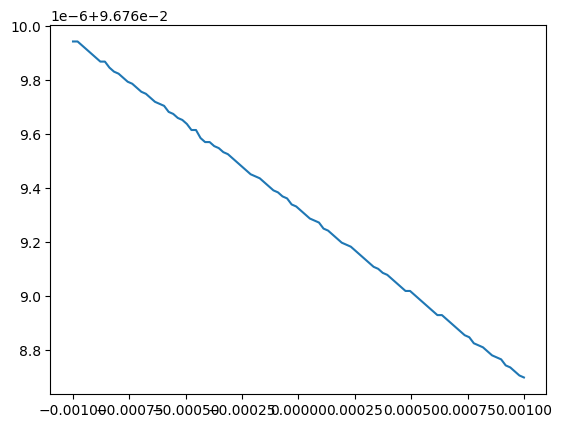

In [13]:
# WITH TRAINING DATASET ON [-1,1]
model = MLP_bn(1, 1 , 100, 10)
model.train()
x = torch.linspace(-1, 1, 100).view(-1, 1)
y = model(x)

plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

model.eval()
x = torch.linspace(-1e-3, 1e-3, 100).view(-1, 1)
y = model(x)

plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

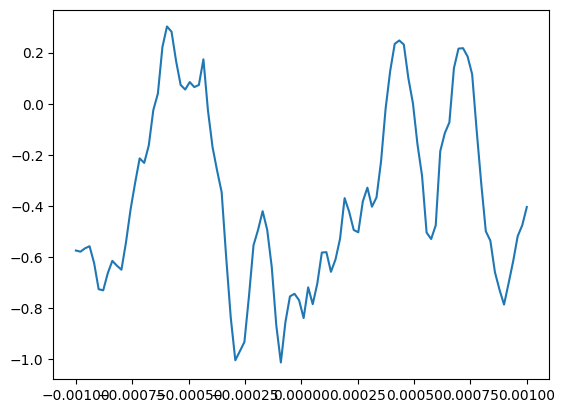

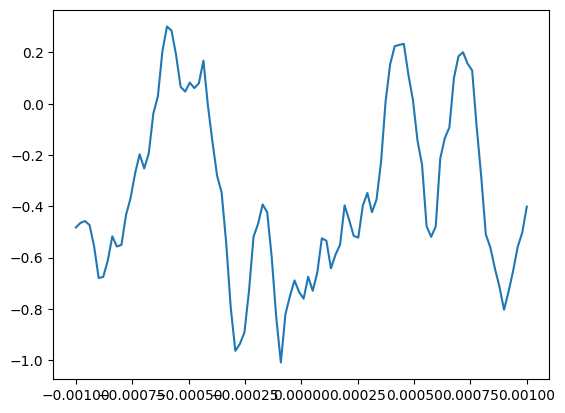

In [14]:
# WITH TRAINING DATASET ON [-1e-3,1e-3]
model = MLP_bn(1, 1 , 100, 10)
model.train()
x = torch.linspace(-1e-3, 1e-3, 100).view(-1, 1)
for _ in range(1000):
    y = model(x)

plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

model.eval()
x = torch.linspace(-1e-3, 1e-3, 100).view(-1, 1)
y = model(x)

plt.plot(x.detach().numpy(), y.detach().numpy())
plt.show()

# Part B - Stability, outliers and overfitting
We now investigate the generaliation capabilities of MLPs on a simple regression task: our aim is to lear the function $y=\sin(3 x)$. However, a small number of training samples (denoted as **outliers**) were randomly perturbed by a large factor (of order 100).

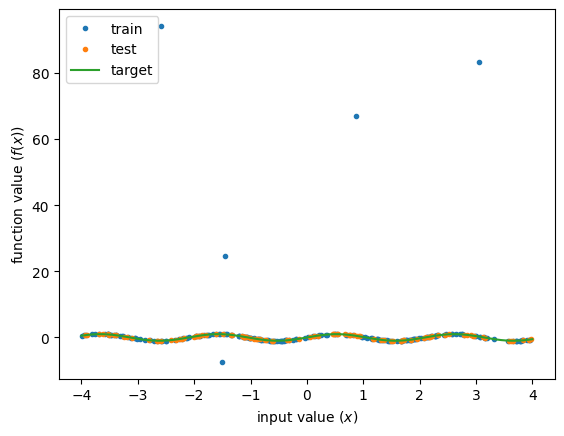

In [17]:
batch_size = 20
num_points = 200
outlier_std = 100
num_outliers = 5
torch.manual_seed(1234)

x_train = 4 * (2 * torch.rand(num_points, 1) - 1)
outlier_noise = torch.zeros_like(x_train)
outlier_noise[torch.randperm(num_points)[:num_outliers]] = outlier_std * torch.randn(num_outliers, 1)
y_train_clean = torch.sin(3 * x_train)
train_dataset = torch.utils.data.TensorDataset(x_train, y_train_clean, outlier_noise)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

x_test = 4 * (2 * torch.rand(100, 1) - 1)
y_test = torch.sin(3 * x_test)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

def plot_function(model=None, zoom=True):
    x = torch.linspace(-4, 4, 1000)
    plt.plot(x_train, y_train_clean + outlier_noise, '.', label="train")
    plt.plot(x_test, y_test, '.', label="test")
    plt.plot(x, torch.sin(3 * x), label="target")
    if model is not None:
        output = model(x.unsqueeze(1).to(device)).cpu().detach().numpy()
        plt.plot(x, output, label="model")
    plt.legend()
    if zoom:
        plt.ylim([-2, 2])
    plt.xlabel('input value ($x$)')
    plt.ylabel('function value ($f(x)$)')
    plt.show()

plot_function(zoom=False)

Create three functions:

1.   A function `train_epoch(model, optimizer, clipping_threshold=None)` that trains the model for one epoch and applies gradient clipping if `clipping_threshold` is not `None`.
2.   A function `test(model)` that returns the loss over the test set.
3.   A function `train(model, optimizer, num_epochs, clipping_threshold=None)` that performs `num_epochs` epochs of training (with the MSE loss), and plots (in a figure) the train and test losses at each epoch.


In [22]:
def train_epoch(model, optimizer, clipping_threshold = None):
    model.train()
    loss_function = nn.MSELoss(reduction='sum')
    losses = []
    for input, target, outlier_noise in train_dataloader:
        input, target, outlier_noise = input.to(device), target.to(device), outlier_noise.to(device)
        output = model(input)
        target_with_outliers = target + outlier_noise
        loss = loss_function(output,target_with_outliers)
        optimizer.zero_grad()
        loss.backward()
        if clipping_threshold is not None :
            torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_threshold)
        optimizer.step()
        loss = loss_function(output,target)
        losses.append(loss.item())
    return np.sum(losses) / len(train_dataloader)

def test(model):
    model.eval()
    loss_function = nn.MSELoss(reduction='sum')
    losses = []
    with torch.no_grad():
        for input, target in test_dataloader:
            input, target = input.to(device), target.to(device)
            output = model(input)
            loss = loss_function(output, target)
            losses.append(loss.item())
    return np.sum(losses) / len(test_dataloader)

def train(model, optimizer, num_epochs, clipping_threshold=None):
    train_losses =[]
    test_losses = []
    for epoch in tqdm(range(num_epochs)):
        train_losses.append(train_epoch(model,optimizer, clipping_threshold))
        test_losses.append(test(model))
    plt.plot(train_losses,label="train")
    plt.plot(test_losses,label="test")
    plt.legend()
    plt.show()
    return train_losses[-1],test_losses[-1], model


Train an MLP of width $10^3$ and depth $4$ with Adam (lr=1e-3), and plot the target function and the output of the model. The model tries to fit the outliers, lead to a poor performance on the test set.

100%|██████████| 400/400 [00:10<00:00, 36.91it/s]


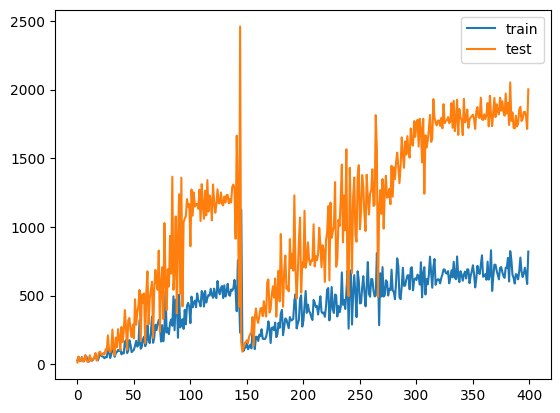

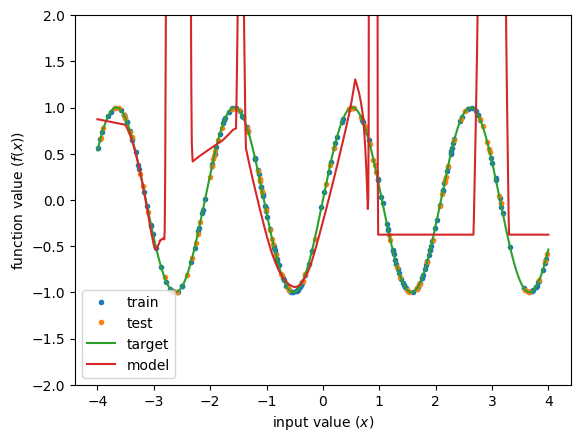

In [23]:
model = MLP(1,1,int(1e3),4).to(device)
optimizer  = torch.optim.Adam(model.parameters(),lr=1e-3)
train_loss, test_loss, model = train(model, optimizer, 400)
plot_function(model)

We are going to test 3 methods: 1) adding batch norm layers, 2) adding gradient clipping, and 3) adding regularization (aka weight decay). Test all three methods. Try to find reasonable parameters for clipping and weight decay by hand. Is the output of the model smoother? Can we reduce the impact of outliers?

100%|██████████| 400/400 [00:12<00:00, 30.86it/s]


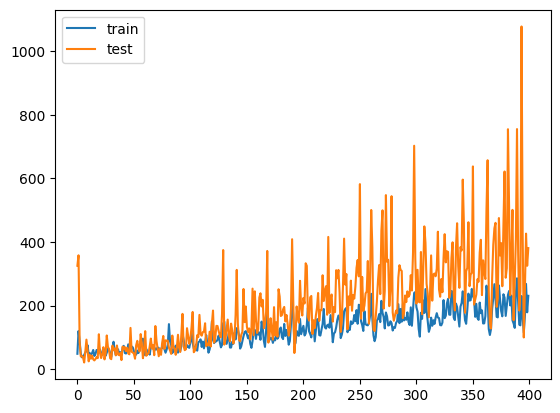

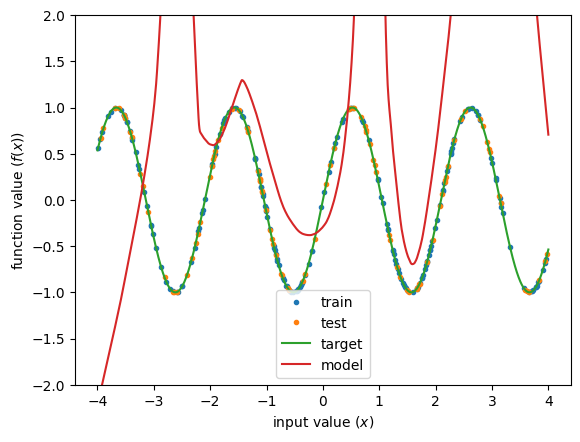

In [24]:
model = MLP_bn(1,1,int(1e3),4).to(device)
optimizer  = torch.optim.Adam(model.parameters(),lr=1e-3)
train_loss, test_loss, model = train(model, optimizer, 400)
plot_function(model)

100%|██████████| 400/400 [00:12<00:00, 33.05it/s]


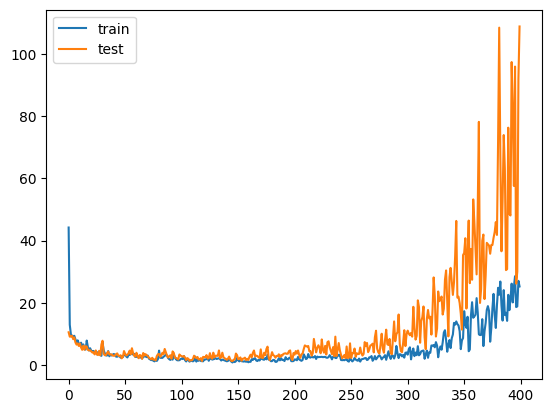

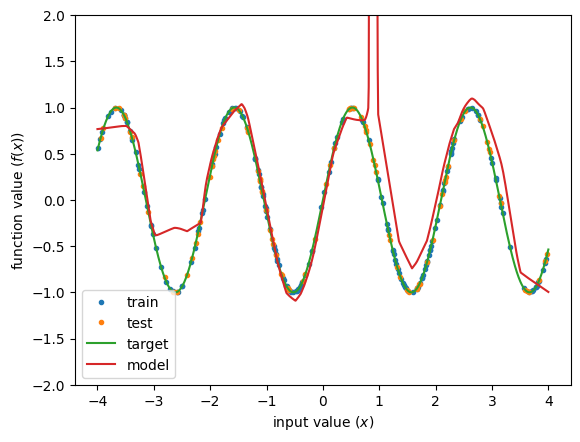

In [26]:
model = MLP(1,1,int(1e3),4).to(device)
optimizer  = torch.optim.Adam(model.parameters(),lr=1e-3)
train_loss, test_loss, model = train(model, optimizer, 400,1e-1)
plot_function(model)

100%|██████████| 400/400 [00:11<00:00, 35.58it/s]


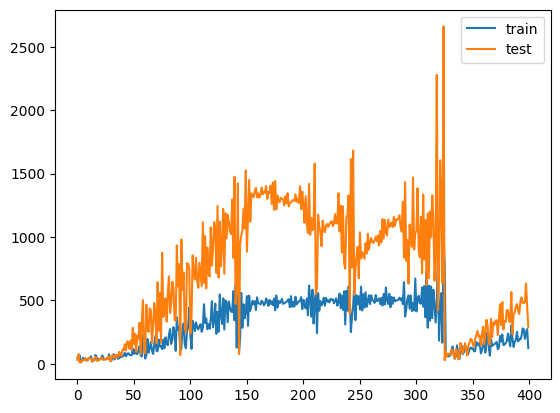

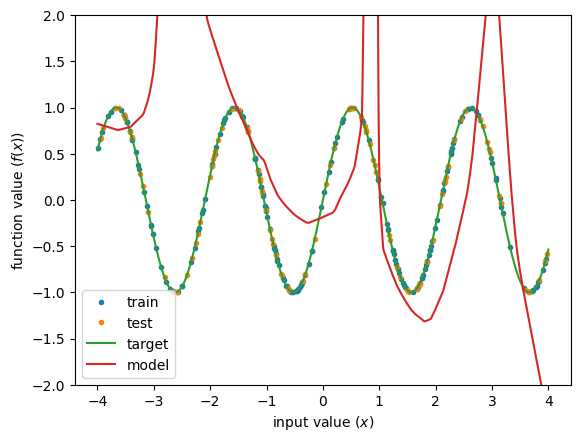

In [27]:
model = MLP(1,1,int(1e3),4).to(device)
optimizer  = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-1)
train_loss, test_loss, model = train(model, optimizer, 400)
plot_function(model)

Train the model with all three methods toghether. Is the test error better?

100%|██████████| 400/400 [00:14<00:00, 27.39it/s]


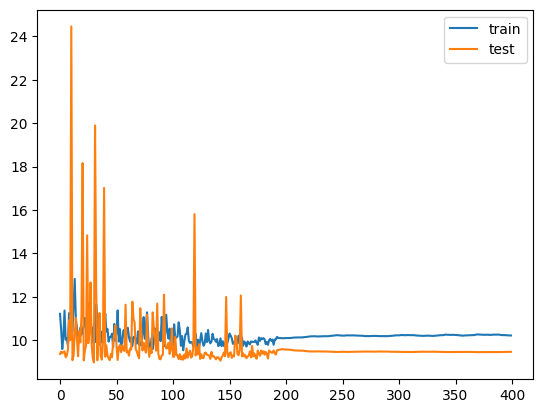

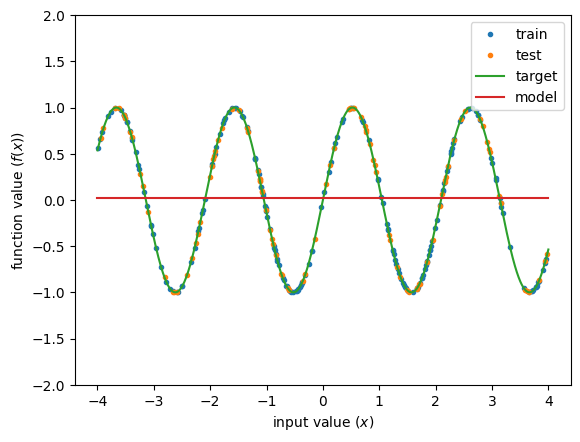

In [29]:
model = MLP_bn(1,1,int(1e3),4).to(device)
optimizer  = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-1)
train_loss, test_loss, model = train(model, optimizer, 400, 1e-1)
plot_function(model)

100%|██████████| 400/400 [00:15<00:00, 26.12it/s]


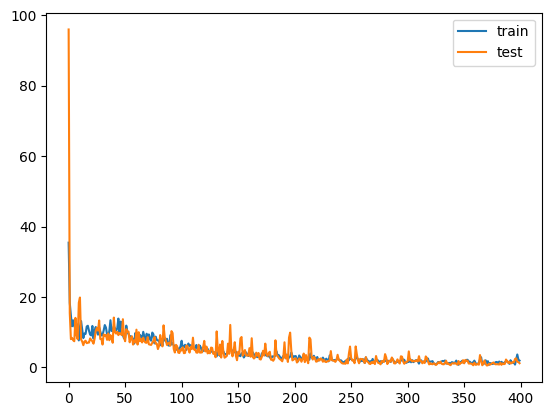

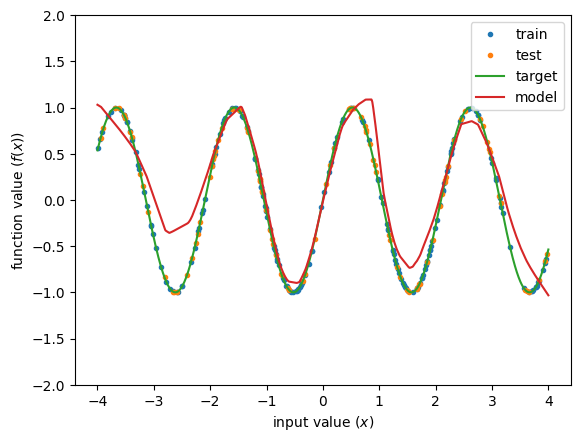

In [32]:
model = MLP_bn(1,1,int(1e3),4).to(device)
optimizer  = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-4)
train_loss, test_loss, model = train(model, optimizer, 400, 1e-1)
plot_function(model)


### Bonus question
Use a validation set to find optimal parameters for the learning rate, weigth decay and gradient clipping.

In [ ]:
### YOUR CODE HERE ###

# Part C - Adversarial examples

In this part, we will look at [adversarial examples](https://arxiv.org/abs/1607.02533): "An adversarial example is a sample of input data which has been modified very slightly in a way that is intended to cause a machine learning classifier to misclassify it. In many cases, these modifications can be so subtle that a human observer does not even notice the modification at all, yet the classifier still makes a mistake. Adversarial examples pose security concerns because they could be used to perform an attack on machine learning systems..."

Rules of the game:
- the attacker cannot modify the classifier, i.e. the neural net with the preprocessing done on the image before being fed to the network.
- even if the attacker cannot modify the classifier, we assume that the attacker knows the architecture of the classifier. Here, we will work with `resnet18` and the standard Imagenet normalization.
- the attacker can only modify the physical image fed into the network.
- the attacker should fool the classifier, i.e. the label obtained on the corrupted image should not be the same as the label predicted on the original image.

In [ ]:
# Image under attack!
url_car = 'https://cdn130.picsart.com/263132982003202.jpg?type=webp&to=min&r=640'
response = requests.get(url_car)
img_pil = Image.open(io.BytesIO(response.content))
plt.imshow(img_pil);

In [ ]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = torchvision.transforms.Compose([
   torchvision.transforms.Resize((224,224)),
   torchvision.transforms.ToTensor(),
   normalize
])

net = torchvision.models.resnet18(pretrained=True)
net.eval()

for p in net.parameters():
    p.requires_grad = False

x = preprocess(img_pil).clone().unsqueeze(0)
scores = net(x)

In [ ]:
# download the imagenet category list
LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

def print_preds(scores):
    # print the predictions with their 'probabilities' from the scores
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    # output the prediction
    for i in range(0, 5):
        print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    return idx

_ = print_preds(scores)

In [ ]:
t_std = torch.Tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
t_mean = torch.Tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)

def plot_img_tensor(img):
    plt.imshow(np.transpose(img.detach().numpy(), [1,2,0]))

In [ ]:
# here we display an image given as a tensor
x_img = (x * t_std + t_mean).squeeze(0)
plot_img_tensor(x_img)

## C.1 - Creating the attack
First, you will implement *Fast gradient sign method (FGSM)* which is described in Section 2.1 of [Adversarial examples in the physical world](https://arxiv.org/abs/1607.02533). The idea is simple, suppose you have an image $\mathbf{x}$ and when you pass it through the network, you get the 'true' label $y$. You know that your network has been trained by minimizing the loss $J(\mathbf{\theta}, \mathbf{x}, y)$ with respect to the parameters of the network $\theta$. Now, $\theta$ is fixed as you cannot modify the classifier so you need to modify $\mathbf{x}$. In order to do so, you can compute the gradient of the loss with respect to $\mathbf{x}$ i.e. $\nabla_{\mathbf{x}} J(\mathbf{\theta}, \mathbf{x}, y)$ and use it as follows to get the modified image $\tilde{\mathbf{x}}$:
$$
\tilde{\mathbf{x}} = \text{Clamp}\left(\mathbf{x} + \epsilon *
\text{sign}(\nabla_{\mathbf{x}} J(\mathbf{\theta}, \mathbf{x}, y)),0,1\right),
$$
where $\text{Clamp}(\cdot, 0,1)$ ensures that $\tilde{\mathbf{x}}$ is a proper image.
Note that if instead of sign, you take the full gradient, you are now following the gradient i.e. increasing the loss $J(\mathbf{\theta}, \mathbf{x}, y)$ so that $y$ becomes less likely to be the predicted label.

1. Implement this attack. Make sure to display the corrupted image.

2. For what value of epsilon is your attack successful? What is the predicted class then?

3. Plot the sign of the gradient and pass this image through the network. What prediction do you obtain? Compare to [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)

In [ ]:
# your implementation of the attack
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient

    # Create the perturbed image by adjusting each pixel of the input image

    # Adding clipping to maintain [0,1] range

    # Return the perturbed image
    return perturbed_image

In [ ]:
idx = 656 #minivan
criterion = nn.CrossEntropyLoss()
x_img.requires_grad = True
scores = net(normalize(x_img).unsqueeze(0))
target = torch.tensor([idx])

### YOUR CODE HERE: compute the loss to backpropagate ###

_ = print_preds(scores)

In [ ]:
# your attack here
epsilon = 0
x_att = fgsm_attack(x_img,epsilon,?)

In [ ]:
# the new prediction for the corrupted image
scores = net(normalize(x_att).unsqueeze(0))
_ = print_preds(scores)

In [ ]:
# can you see the difference?
plot_img_tensor(x_att)

In [ ]:
# do not forget to plot the sign of the gradient
gradient = ### YOUR CODE HERE ###
plot_img_tensor((1+gradient)/2)

In [ ]:
# what is the prediction for the gradient?
scores = net(normalize(gradient).unsqueeze(0))
_ = print_preds(scores)

## C.2 - Transforming a car into a cat

We now implement the *Iterative Target Class Method (ITCM)* as defined by equation (4) in [Adversarial Attacks and Defences Competition](https://arxiv.org/abs/1804.00097)

To test it, we will transform the car (labeled minivan by our `resnet18`) into a [Tabby cat](https://en.wikipedia.org/wiki/Tabby_cat) (classe 281 in Imagenet). But you can try with any other target.

Implement the ITCM and make sure to display the resulting image.

In [ ]:
x = preprocess(img_pil).clone()
xd = preprocess(img_pil).clone()
xd.requires_grad = True

In [ ]:
idx = 281 #tabby
optimizer = optim.SGD([xd], lr=0.01)

for i in range(200):
    ### YOUR CODE HERE ###

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss.item())

    _ = print_preds(output)
    print(i,'-----------------')

    # TODO: break the loop once we are satisfied
    if ?:
        break

In [ ]:
_ = print_preds(output)

In [ ]:
# plot the corrupted image
